In [1]:
# Imports
import os
import sys
import torch
import numpy as np
from tqdm import tqdm
import SimpleITK as sitk
from matplotlib import pyplot as plt

# Add the setup_data_vars function as we will need it to find the directory for the training data.
dir1 = os.path.abspath(os.path.join(os.path.abspath(''), '..', '..'))
if not dir1 in sys.path: sys.path.append(dir1)

from utils.environment import setup_data_vars
setup_data_vars()

dir2 = os.path.abspath(os.path.join(os.path.abspath(''), '..', '0_utils'))
if not dir2 in sys.path: sys.path.append(dir2)

from dataload_handler import DataLoaderHandler
from checkpoint_handler import CheckpointHandler

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [9]:
import argparse

parser = argparse.ArgumentParser()

# Inspired by orginal code from the MedSAM/extensions/point_prompt

# 1. Add the anatomy on which we will fine-tune
parser.add_argument(
    'anatomy',
    type=str,
    help='Anatomy on which to fine-tune the model. Note: this is case sensitive, please capitalize the first letter and accronyms such as CTVn or CTVp.',
)

parser.add_argument(
    'checkpoint',
    type=int,
    help='Whether to use the checkpoint for the anatomy or whether to use the vanialla model the model comes with (True means use checkpoint)',
)


_StoreAction(option_strings=[], dest='checkpoint', nargs=None, const=None, default=None, type=<class 'int'>, choices=None, required=True, help='Whether to use the checkpoint for the anatomy or whether to use the vanialla model the model comes with (True means use checkpoint)', metavar=None)

In [13]:
args = parser.parse_args(
    # ['CTVn', '1']
)

anatomy = args.anatomy
checkpoint_arg = bool(args.checkpoint)

print('Anatomy: ', anatomy)
print('Checkpoint: ', checkpoint_arg)

Anatomy:  CTVn
Checkpoint:  True


## Setup classes for loading up the stuff

In [40]:
lowres = True
save_dir = os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', anatomy)
checkpoint_path = os.path.join(os.environ['PROJECT_DIR'], 'models', 'MedSAM', 'work_dir', 'MedSAM', 'medsam_vit_b.pth')



model_path = os.path.join(save_dir, 'checkpoint_best.pth')
data_split = os.path.join(save_dir, 'data_splits.json')
img_dir = os.path.join(os.environ.get('MedSAM_preprocessed_lowres'), 'imgs')
gt_dir = os.path.join(os.environ.get('MedSAM_preprocessed_lowres'), 'gts', anatomy)
batch_size = 1
num_workers = 16

use_boxes = True
use_positive_points = False

assert os.path.exists(model_path), f"Model path {model_path} does not exist."
assert os.path.exists(data_split), f"Data split {data_split} does not exist."
assert os.path.exists(img_dir), f"Raw data {img_dir} does not exist."
assert os.path.exists(gt_dir), f"Ground truth data {gt_dir} does not exist."

In [41]:
dlh = DataLoaderHandler(save_dir = save_dir,
                        image_dir = img_dir,
                        gt_dir = gt_dir,
                        batch_size = batch_size,
                        num_workers = num_workers,
                        data_aug = False,
                        max_points = 0,
                        box_padding = 5,
                        max_box_points = 5)
dlh.load_split_from_json()
dlh.setup_specific_dataloader('validation')
dlh.validation_image_ids

Dataset size (6.6 GiB) fits in cache limit (20 GiB). Allocating space to cache all 6718 samples.


{2, 10, 11, 16, 38, 42, 43, 46, 49, 51, 56, 57, 66, 71, 73, 74, 77, 79, 92, 93}

In [42]:
cph = CheckpointHandler(save_dir, checkpoint_path, device)
if checkpoint_arg and cph.checkpoint_exists():
    model, optimizer, epoch, _ = cph.load_checkpoint()
    print(f'Loaded the model for anatomy {anatomy} from epoch {epoch}')
else:
    model, optimizer = cph.load_base_checkpoint()
    print(f'Loaded the base model of MedSAM')

Loaded the model for anatomy CTVn from epoch 75


## Main validaiton loop

In [43]:
import pandas as pd

# create a pandas dataframe to store the name, axis, dice, jaccard, volume_similarity, apl, surface_distance, and hausdorff_distance

df = pd.DataFrame(columns=['name', 'axis', 'dice', 'jaccard', 'volume_similarity', 'apl', 'surface_distance', 'hausdorff_distance'])

validation_file_name = f'validation{"_checkpoint" if checkpoint_arg else "_base"}.csv'

# load in the processed data if it already exists
# if os.path.exists(os.path.join(save_dir, 'validation.csv')):
#     df = pd.read_csv(os.path.join(save_dir, 'validation.csv'))

In [44]:
df

,name,axis,dice,jaccard,volume_similarity,apl,surface_distance,hausdorff_distance


In [45]:
import SimpleITK as sitk
import os

def upsample_sitk_image_to_original(y_gt_sitk, y_pred_sitk, image_name, axis_num):
    # Get image id from image_name
    image_id = int(image_name.split('_')[2].split('-')[0])
    original_file_path = os.path.join(
        os.environ.get('nnUNet_raw'),
        os.environ.get('Anorectum'),
        os.environ.get('data_trainingImages'),
        # f'zzAMLART_{image_id:03d}.nii.gz'
        f'zzAMLART_{image_id:03d}_0000.nii.gz'
    )
    # slice_num = int(image_name.split('_')[2].split('-')[1][:-4])

    # Read the original image
    reader = sitk.ImageFileReader()
    reader.SetFileName(original_file_path)
    reader.LoadPrivateTagsOn()
    reader.ReadImageInformation()
    original_spacing = list(reader.GetSpacing())
    original_size = list(reader.GetSize())
    
    # reshape so that the original axis order is preserved

    # (X, X, 1)

    if axis_num == 0:
        y_gt_sitk = sitk.PermuteAxes(y_gt_sitk, [2, 0, 1])
        y_pred_sitk = sitk.PermuteAxes(y_pred_sitk, [2, 0, 1])
    elif axis_num == 1:
        y_gt_sitk = sitk.PermuteAxes(y_gt_sitk, [0, 2, 1])
        y_pred_sitk = sitk.PermuteAxes(y_pred_sitk, [0, 2, 1])

    original_size[axis_num] = 1
    # original_spacing[axis_num] = 1

    y_gt_sitk_new = sitk.Resample(y_gt_sitk, original_size, sitk.Transform(), sitk.sitkNearestNeighbor, y_gt_sitk.GetOrigin(), original_spacing, y_gt_sitk.GetDirection(), 0.0, y_gt_sitk.GetPixelID())
    y_pred_sitk_new = sitk.Resample(y_pred_sitk, original_size, sitk.Transform(), sitk.sitkNearestNeighbor, y_pred_sitk.GetOrigin(), original_spacing, y_pred_sitk.GetDirection(), 0.0, y_pred_sitk.GetPixelID())

    if axis_num == 0:
        y_gt_sitk_new = sitk.PermuteAxes(y_gt_sitk_new, [1, 2, 0])
        y_pred_sitk_new = sitk.PermuteAxes(y_pred_sitk_new, [1, 2, 0])
    elif axis_num == 1:
        y_gt_sitk_new = sitk.PermuteAxes(y_gt_sitk_new, [0, 2, 1])
        y_pred_sitk_new = sitk.PermuteAxes(y_pred_sitk_new, [0, 2, 1])

    return y_gt_sitk_new, y_pred_sitk_new
    
# gt_up, pred_up = upsample_sitk_image_to_original(y_gt_sitk, ypred_sitk, image_name, image_axis)
# print(y_gt_sitk.GetSize(), gt_up.GetSize(), ypred_sitk.GetSize(), pred_up.GetSize())
# print(np.unique(sitk.GetArrayFromImage(gt_up)), np.unique(sitk.GetArrayFromImage(pred_up)))

# # plot the comparison between upsampled and original images

# def plot_comparison(gt, pred, gt_up, pred_up):
#     fig, ax = plt.subplots(2, 2, figsize=(10, 10))
#     ax[0, 0].imshow(sitk.GetArrayFromImage(gt)[0], cmap='gray')
#     ax[0, 0].set_title('Original GT')
#     ax[0, 1].imshow(sitk.GetArrayFromImage(pred)[0], cmap='gray')
#     ax[0, 1].set_title('Original Pred')
#     ax[1, 0].imshow(sitk.GetArrayFromImage(gt_up)[0], cmap='gray')
#     ax[1, 0].set_title('Upsampled GT')
#     ax[1, 1].imshow(sitk.GetArrayFromImage(pred_up)[0], cmap='gray')
#     ax[1, 1].set_title('Upsampled Pred')
#     plt.show()

# plot_comparison(y_gt_sitk, ypred_sitk, gt_up, pred_up)

In [ ]:
from platipy.imaging.label.comparison import compute_metric_total_apl, compute_surface_dsc, compute_metric_hd
import cv2
import numpy as np

overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

length_of_val_loader = len(dlh.val_loader)

# iterate through the validation loader
for i, batch in tqdm(enumerate(dlh.val_loader), total=length_of_val_loader):
    image_name = batch["image_name"][0]
    image_axis = batch["axis"].item()

    # check if we have already processed this name and axis
    if image_name in df.name.values and image_axis in df.axis.values:
        continue

    # Get data
    image = batch["image"].to(device)
    gt2D = batch["gt2D"].to(device)
    # coords_torch = batch["coords"].squeeze().to(device) # ([B, Ps, 2])
    boxes_torch = batch["boxes"].squeeze().reshape(batch_size, -1, 4).to(device) # ([B, Ps, 4])
    axis = batch["axis"].squeeze() # ([B])
    
    medsam_preds = []
    medsam_segs = []

    for b in torch.unique(boxes_torch.squeeze().reshape(-1, batch_size, 4), dim=0):
        b = b.reshape(batch_size, 1, 4)
        # print(b)
        medsam_lite_pred = model(image, None, b)
        medsam_seg_prob = torch.sigmoid(medsam_lite_pred)
        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

        medsam_preds.append(medsam_lite_pred.detach().cpu())
        medsam_segs.append(medsam_seg)

    medsam_preds = torch.tensor(np.stack(medsam_preds))
    medsam_segs = torch.tensor(np.stack(medsam_segs))

    # do an OR operation on the medsam_segs
    medsam_seg = medsam_segs.sum(dim=0)

    # Get evaluation metrics
    y_gt_sitk = sitk.GetImageFromArray(gt2D[0].detach().cpu().numpy().astype(np.uint8))
    ypred_sitk = sitk.GetImageFromArray(medsam_seg[None, :, :].numpy().astype(np.uint8))

    # print(y_gt_sitk.GetSize(), ypred_sitk.GetSize())
    # print(y_gt_sitk.GetSpacing(), ypred_sitk.GetSpacing())
    
    # TODO REMOVE THIS
    y_gt_sitk, ypred_sitk = upsample_sitk_image_to_original(y_gt_sitk, ypred_sitk, image_name, image_axis)

    # print(y_gt_sitk.GetSize(), ypred_sitk.GetSize())
    # print(y_gt_sitk.GetSpacing(), ypred_sitk.GetSpacing())

    # ##############################################################

    # plot the the prediction vs the ground truth zoomed into the area of interest

    # Find contours in the segmentation map
    # contours, _ = cv2.findContours(np.uint8(sitk.GetArrayFromImage(ypred_sitk)[0]), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # # Initialize list to store bounding boxes
    # bounding_boxes = []

    # x_min, y_min, x_max, y_max = float('inf'), float('inf'), 0, 0

    # # Loop through contours to find bounding boxes
    # for contour in contours:
    #     # Get bounding box coordinates
    #     x, y, w, h = cv2.boundingRect(contour)
    #     x_min, y_min, x_max, y_max = min(x, x_min), min(y, y_min), max(x + w, x_max), max(y + h, y_max)
    #     # bounding_boxes.append([x - 20, y - 20, x + w + 20, y + h + 20])  # Format: (x_min, y_min, x_max, y_max)

    # # plot the ROI

    # fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # p = 15

    # ax[0].imshow(sitk.GetArrayFromImage(y_gt_sitk)[0][max(0, y_min - p):y_max + p, max(0, x_min - p):x_max + p], cmap='gray')
    # ax[0].set_title('Ground Truth')
    # ax[0].axis('off')

    # ax[1].imshow(sitk.GetArrayFromImage(ypred_sitk)[0][max(0, y_min - p):y_max + p, max(0, x_min - p):x_max + p], cmap='gray')
    # ax[1].set_title('Prediction')
    # ax[1].axis('off')

    # plt.show()

    # ##############################################################

    overlap_measures_filter.Execute(y_gt_sitk, ypred_sitk)
                
    dice = overlap_measures_filter.GetDiceCoefficient()
    jaccard = overlap_measures_filter.GetJaccardCoefficient()
    volume_similarity = overlap_measures_filter.GetVolumeSimilarity()

    apl = compute_metric_total_apl(y_gt_sitk, ypred_sitk, 0.5)
    surface_dsc = compute_surface_dsc(y_gt_sitk, ypred_sitk, 0.5)
    hd = compute_metric_hd(y_gt_sitk, ypred_sitk)

    # add metrics to dataframe

    new_record = pd.DataFrame([
        {'name': image_name, 'axis': image_axis, 'dice': dice, 'jaccard': jaccard, 'volume_similarity': volume_similarity, 'apl': apl, 'surface_distance': surface_dsc, 'hausdorff_distance': hd}
    ])

    df = pd.concat([df, new_record], ignore_index=True)

    if i % 10 == 0:
        # save the dataframe to a csv file
        df.to_csv(os.path.join(save_dir, validation_file_name), index=False)

df.to_csv(os.path.join(save_dir, validation_file_name), index=False)

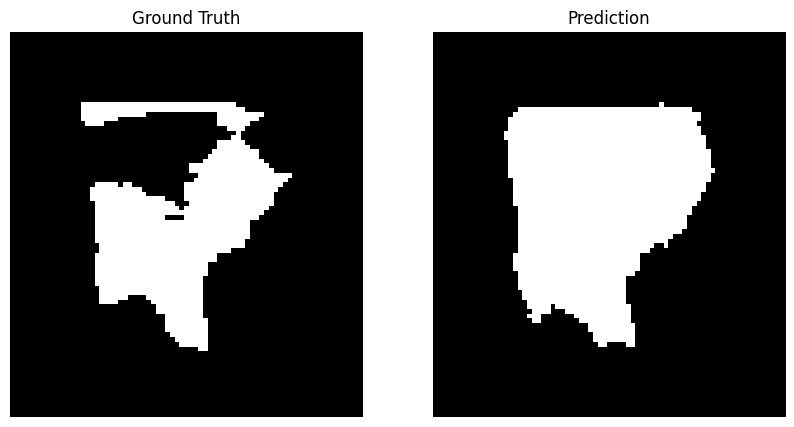

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

p = 15

ax[0].imshow(sitk.GetArrayFromImage(y_gt_sitk)[0][max(0, y_min - p):y_max + p, max(0, x_min - p):x_max + p], cmap='gray')
ax[0].set_title('Ground Truth')
ax[0].axis('off')

ax[1].imshow(sitk.GetArrayFromImage(ypred_sitk)[0][max(0, y_min - p):y_max + p, max(0, x_min - p):x_max + p], cmap='gray')
ax[1].set_title('Prediction')
ax[1].axis('off')

plt.show()

In [ ]:
def compute_apl(label_ref, label_test, distance_threshold_mm=3):
    """
    helper function for computing the added path length

    Args:
        label_ref (sitk.Image): The reference (ground-truth) label
        label_test (sitk.Image): The test label
        distance_threshold_mm (float): Distances under this threshold will not contribute to the
            added path length

    Returns:
        float: The total (slice-wise) added path length in mm
    """
    added_path_length_list = []
    n_slices = label_ref.GetSize()[2]

    # convert the distance threshold to voxel units
    distance = int(np.ceil(distance_threshold_mm / np.mean(label_ref.GetSpacing()[:2])))

    # iterate over each slice
    for i in range(n_slices):

        if (
            sitk.GetArrayViewFromImage(label_ref)[i].sum()
            + sitk.GetArrayViewFromImage(label_test)[i].sum()
        ) == 0:
            continue

        label_ref_contour = sitk.LabelContour(label_ref[:, :, i])
        label_test_contour = sitk.LabelContour(label_test[:, :, i])

        if distance_threshold_mm > 0:
            kernel = [int(distance) for k in range(2)]
            label_test_contour = sitk.BinaryDilate(label_test_contour, kernel)

        # mask out the locations in agreement
        added_path = sitk.MaskNegated(label_ref_contour, label_test_contour)

        # add up the voxels on the added path
        added_path_length = sitk.GetArrayViewFromImage(added_path).sum()
        added_path_length_list.append(added_path_length)

    return added_path_length_list

compute_apl(y_gt_sitk, ypred_sitk, 1.0)

[69]

## plot the metrics per axis and total

In [ ]:
df

,name,axis,dice,jaccard,volume_similarity,apl,surface_distance,hausdorff_distance
0,CT_zzAMLART_093-317.npy,2,0.884404,0.792763,-0.055046,0.000000,1.000000,2.762136
1,CT_zzAMLART_077-196.npy,1,0.880952,0.787234,-0.095238,0.000000,1.000000,2.683966
2,CT_zzAMLART_038-152.npy,0,0.719486,0.561873,-0.415418,6.539062,0.773438,9.108994
3,CT_zzAMLART_002-153.npy,0,0.955932,0.915584,0.020339,0.000000,1.000000,2.000000
4,CT_zzAMLART_077-077.npy,0,0.923963,0.858672,-0.013825,0.000000,1.000000,2.929686
...,...,...,...,...,...,...,...,...
4593,CT_zzAMLART_051-073.npy,0,0.906422,0.828859,0.011009,0.000000,1.000000,2.929686
4594,CT_zzAMLART_002-319.npy,2,0.893824,0.808030,-0.054129,0.000000,0.962733,4.367320
4595,CT_zzAMLART_071-190.npy,0,0.954436,0.912844,0.052758,0.000000,1.000000,2.000000
4596,CT_zzAMLART_073-105.npy,0,0.901961,0.821429,0.058824,0.000000,1.000000,2.539062


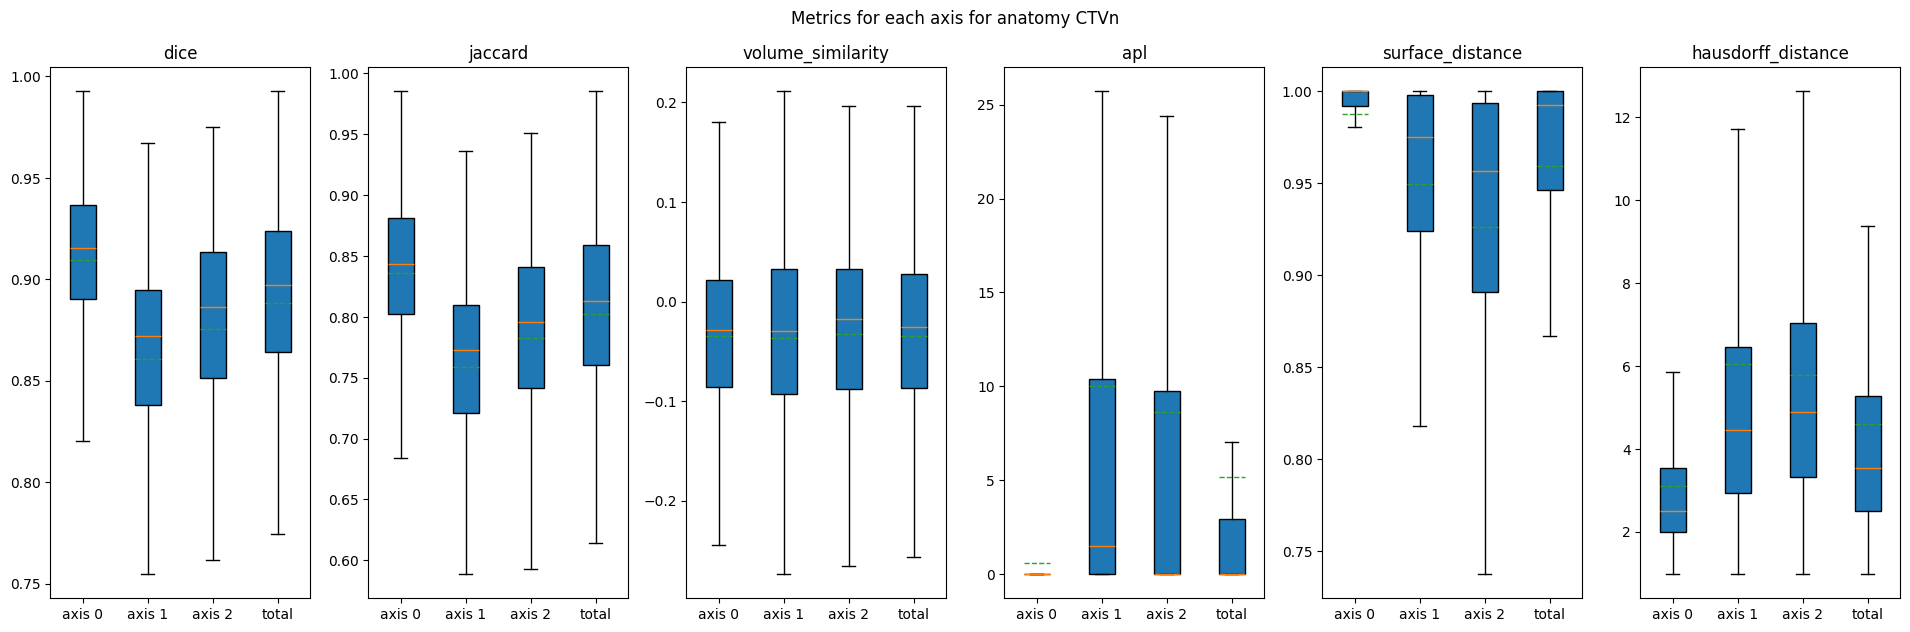

<Figure size 640x480 with 0 Axes>

In [ ]:
# for each axis, plot the metrics

metrics = ['dice', 'jaccard', 'volume_similarity', 'apl', 'surface_distance', 'hausdorff_distance']

ncols = len(metrics)
nrows = 1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*2*1.6, nrows*4*1.6))
axs = axs.reshape(nrows, ncols)

for i in range(ncols):
    # get the column values
    column = metrics[i]

    # set the title of the cell to the metric type
    axs[0, i].set_title(column)

    # for each axis, plot the metric
    for axis in range(3):
        data = df[df.axis == axis]
        
        # for each axis, plot the boxplot with each axis being a different point on the x-axis labelled with axis-0, axis-1, axis-2.
        axs[0, i].boxplot(data[column], positions=[axis], showfliers=False, meanline=True, showmeans=True, patch_artist=True, widths=(.4))

    # now, we plot the total score across all axis

    axs[0, i].boxplot(df[column], positions=[3], showfliers=False, meanline=True, showmeans=True, patch_artist=True, widths=(.4))
    axs[0, i].set_xticklabels(['axis 0', 'axis 1', 'axis 2', 'total'])
        
    
plt.suptitle(f'Metrics for each axis for anatomy {anatomy}')
plt.tight_layout()
plt.show()

plt.savefig(os.path.join(save_dir, 'validation_metrics.png'))